In [1]:
#@title General imports and LLM music caption

from google.colab import drive
drive.mount('/content/drive/')

!git clone https://github.com/seungheondoh/lp-music-caps.git
%cd lp-music-caps/
!pip install -e .

from IPython.display import clear_output, display

%cd lpmc/music_captioning/
!wget https://huggingface.co/seungheondoh/lp-music-caps/resolve/main/transfer.pth -O exp/transfer/lp_music_caps/last.pth
!python3 captioning.py --gpu 0 --audio_path /content/drive/MyDrive/audio_samples/Disclosure_Happening_30sec.wav > /content/drive/MyDrive/music_desc/music_desc.txt

clear_output()

In [2]:
#@title Mount Google Drive and assign directories

IMAGE_DIR = '/content/drive/MyDrive/image_samples' #@param
AUDIO_DIR = '/content/drive/MyDrive/audio_samples'#@param
IMAGE_DESCRIPTION_PATH = '/content/drive/MyDrive/image_desc'#@param
SAVE_DIR = "/content/drive/MyDrive/results"#@param
most_recent_save_path = ''

#from os import listdir

#file_names = os.listdir(AUDIO_DIR)
#print(file_names[:10])#display first 10 files

In [3]:
#@title Stable Diffusion Image Generation Setup kandinsky model 2.2 and diffusion dependencies installation
!pip install diffusers
!pip install transformers scipy ftfy accelerate

from diffusers import KandinskyV22PriorPipeline, KandinskyV22Pipeline
from diffusers.utils import load_image, make_image_grid
import PIL
import torch
from torchvision import transforms

pipe_prior = KandinskyV22PriorPipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-prior", torch_dtype=torch.float16
)
pipe_prior.to("cuda")


clear_output()

In [4]:
#@title Assign music_desc file description content to a dictionary list variable

import ast

# Initialize an empty list to store the dictionaries
music_tags = []

# Open the file and read line by line
with open('/content/drive/MyDrive/music_desc/music_desc.txt', 'r') as file:
    for line in file:
        # Strip any extra whitespace from the line and convert the string to a dictionary
        entry = ast.literal_eval(line.strip())
        # Append the dictionary to the list
        music_tags.append(entry)

# Print the list to verify
for entry in music_tags:
    print(entry)


{'text': 'The song is an instrumental. The tempo is medium with a strong bass line, steady drumming rhythm, triangle percussion, keyboard accompaniment and other percussion hits. The song is a modern techno dance tune.', 'time': '0:00-10:00'}
{'text': 'This song contains a digital techno drum with a kick on every beat. A sub-bass is inviting to dance along with synth pluck sounds playing a melody in a higher key along with a female voice. A very low pitched male voice sample comes in for a moment before a synth pad sound playing in the midrange comes in. This song may be playing in a techno club.', 'time': '10:00-20:00'}
{'text': 'This music is an electronic instrumental. The tempo is fast with synthesiser arrangements, electronic beats, Dj mixer and a repetitive vocal riff. The music is incessant, psychedelic, hypnotic, trippy and trance like with a dance groove. This music is Techno Pop/EDM.', 'time': '20:00-30:00'}


model_index.json:   0%|          | 0.00/250 [00:00<?, ?B/s]

Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/5.01G [00:00<?, ?B/s]

movq/config.json:   0%|          | 0.00/660 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/317 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.67k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/271M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

['The song is an instrumental', 'The tempo is medium with a strong bass line, steady drumming rhythm, triangle percussion, keyboard accompaniment and other percussion hits', 'The song is a modern techno dance tune']
Futurism and Digital Art with neon colors, geometric patterns, and a high-tech aesthetic


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

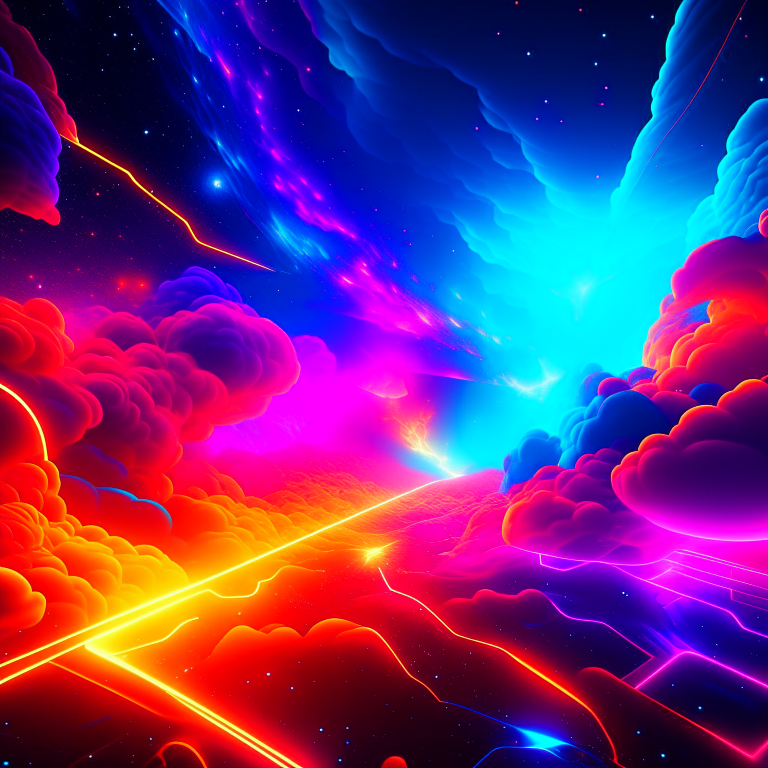

Token indices sequence length is longer than the specified maximum sequence length for this model (79 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['club.']


['This song contains a digital techno drum with a kick on every beat', 'A sub-bass is inviting to dance along with synth pluck sounds playing a melody in a higher key along with a female voice', 'A very low pitched male voice sample comes in for a moment before a synth pad sound playing in the midrange comes in', 'This song may be playing in a techno club']
Futurism and Digital Art with neon colors, geometric patterns, and a high-tech aesthetic


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

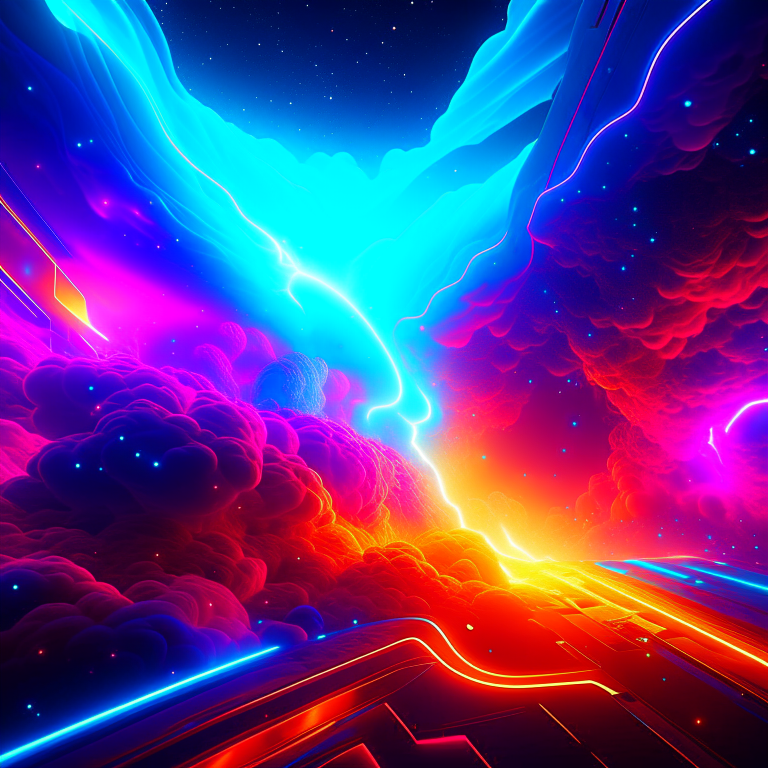

['This music is an electronic instrumental', 'The tempo is fast with synthesiser arrangements, electronic beats, Dj mixer and a repetitive vocal riff', 'The music is incessant, psychedelic, hypnotic, trippy and trance like with a dance groove', 'This music is Techno Pop/EDM']
Pop Art with bright, bold colors, high contrast, and a playful, energetic vibe. Think of the works of Andy Warhol and Roy Lichtenstein


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

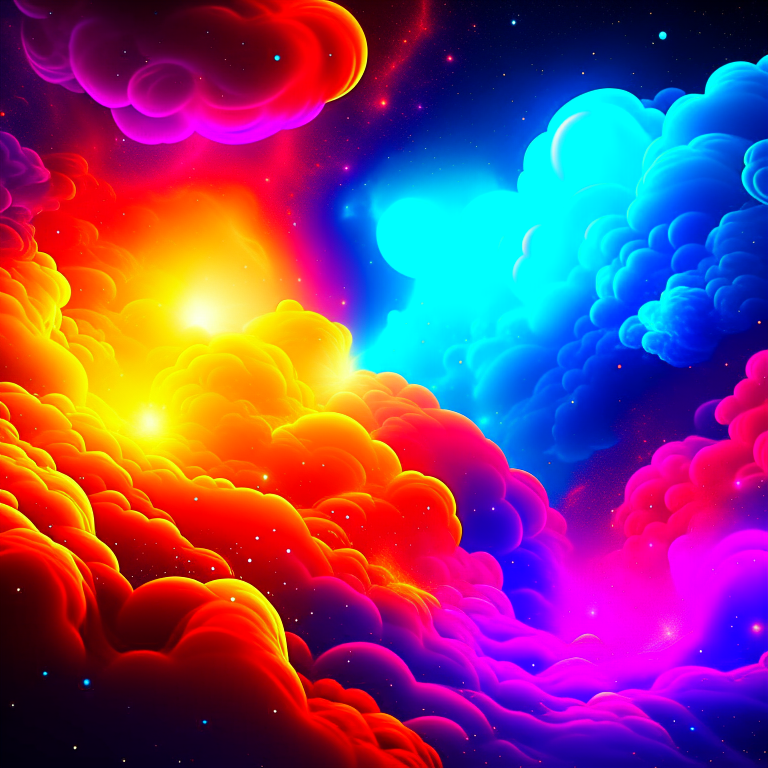

In [5]:
#@title Image Generation according to the song captions using the kadinsky model 2.2

import os

output_dir = "/content/drive/MyDrive/results/" # change output path

#mappings generated with the help of ChatGPT (https://chatgpt.com/)
#each genre is described according to art styles, moods and other visual elements
genre_mappings = {
  "pop": "Pop Art with bright, bold colors, high contrast, and a playful, energetic vibe. Think of the works of Andy Warhol and Roy Lichtenstein",
  "rock": "Grunge and Expressionism with chaotic, intense, and emotive elements. Darker color palettes with splashes of red and black",
  "punk": "Grunge and Expressionism with chaotic, intense, and emotive elements. Darker color palettes with splashes of red and black",
  "jazz": "Abstract Art, often with flowing lines and dynamic compositions. Use of vibrant yet deep colors, echoing the spontaneity and complexity of jazz",
  "blues": "Realism with a focus on somber and moody tones. Use of sepia tones and muted colors to evoke a sense of nostalgia and depth",
  "indie": "Indie Art and Folk Art with whimsical, eclectic, and often minimalistic elements. Use of pastel colors and hand-drawn illustrations",
  "classical": "Impressionism with delicate brushstrokes and soft color palettes. Think of the works of Claude Monet and Pierre-Auguste Renoir",
  "country": "Americana and Western Art with earthy tones and rural themes. Think of wide-open landscapes and vintage illustrations",
  "folk": "Folk Art with simple, rustic, and often narrative elements. Use of earthy colors and traditional patterns",
  "eletronic": "Futurism and Digital Art with neon colors, geometric patterns, and a high-tech aesthetic",
  "techno": "Futurism and Digital Art with neon colors, geometric patterns, and a high-tech aesthetic",
  "electro": "Futurism and Digital Art with neon colors, geometric patterns, and a high-tech aesthetic",
  "house": "Futurism and Digital Art with neon colors, geometric patterns, and a high-tech aesthetic",
  "gospel": "Renaissance and Religious Art with heavenly light, vibrant colors, and ethereal themes. Think of stained glass and divine imagery",
  "latin": "Muralism and Latin American Folk Art with bold colors, dynamic compositions, and cultural motifs",
  "metal": "Gothic and Heavy Metal Art with dark color palettes, skulls, flames, and powerful, dramatic imagery",
  "rap": "Street Art and Graffiti with bold colors, sharp lines, and urban themes. Think of murals and hip-hop culture",
  "hip hop": "Graffiti and Pop Art with bright colors, dynamic compositions, and cultural references. Think of vibrant murals and street culture",
  "reggae": "Rastafarian Art with warm colors, tropical themes, and cultural motifs. Use of greens, yellows, and reds",
  "reggaeton": "Urban Art with bright colors, dynamic patterns, and Latin influences. Think of vibrant cityscapes and dance culture",
  "funk": "Psychedelic Art with vibrant colors, dynamic patterns, and funky, retro elements. Think of the works of Peter Max",
  "disco": "Psychedelic Art with vibrant colors, dynamic patterns, and funky, retro elements. Think of the works of Peter Max",
  "R&B": "Neo-Soul Art with warm colors, elegant lines, and romantic themes. Use of deep blues, purples, and golds"
}

def check_genre(input_desc, genre_dic):

    input_desc = input_desc.lower()

    mapping_in_desc = []

    for genre, mapping in genre_dic.items():
        genre = genre.lower()

        if genre in input_desc and len(mapping_in_desc) == 0: #to only allow 1 mapping tag
            mapping_in_desc.append(mapping)

    return mapping_in_desc

def format_prompts(prompts):
  img_gen_input = ''
  for prompt in prompts:
    img_gen_input += str(prompt)
    img_gen_input += '. '

  return img_gen_input

img_1 = load_image("/content/drive/MyDrive/image_samples/ultra-detailed-nebula-abstract.jpg")
#img_2 = load_image("...") #add variables like this if the user wants to use more than one image as input

negative_prior_prompt ='(((text))), low quality, (bad anatomy), jpeg artifacts, ugly, extra fingers, mutated hands, poorly drawn hands, poorly drawn face, deformed, (((extra limbs))), disfigured, malformed limbs, (((missing arms))), (((missing legs))), (((extra arms))), (((extra legs))), fused fingers, ((too many fingers))'

pipe = KandinskyV22Pipeline.from_pretrained(
    "kandinsky-community/kandinsky-2-2-decoder", torch_dtype=torch.float16
)
pipe.to("cuda")

i=0
for entry in music_tags:
  music_prompt = entry.get('text')
  music_prompt_list = music_prompt.split('.')
  music_prompt_list = [sentence.strip() for sentence in music_prompt_list if sentence.strip()]
  print(music_prompt_list)

  prompts = music_prompt_list

  final_prompt = format_prompts(prompts)

  mapping = check_genre(final_prompt, genre_mappings)
  mapping_string = ' '.join(mapping)
  print(mapping_string)

  if mapping:
    images_texts = [final_prompt, img_1, mapping_string] # if the user is using more than one image as input, it should also be added here, as well as having a respective weight in the line below
    weights = [0.0, 0.7, 0.3] #the weights can be edited as preferred by the user, this is the values we generated results with
  else:
    images_texts = [final_prompt, img_1] # if the algorithm can't find a genre in the LLM caption, we just used the whole caption to generate the image
    weights = [0.3, 0.7]

  prompt = ''

  out = pipe_prior.interpolate(images_texts, weights, negative_prompt=negative_prior_prompt)

  image = pipe(
    image_embeds=out.image_embeds,
    negative_image_embeds=out.negative_image_embeds,
    height=768,
    width=768,
    guidance_scale = 5.0,
    num_inference_steps=50,
  ).images[0]

  display(image)

  save_path = os.path.join(output_dir, f'gen_image_{i}.png')

  image.save(save_path)

  i+=1
